# Fraud Identification Data Preprocessing & Simple Models

The contest description can be found at https://www.kaggle.com/c/ieee-fraud-detection/overview.

## Settings

In [ ]:
# Data preprocessing settings
nullValueThreshold = 0.9
exportData = False

# Which models to run
runSupportVectorMachine = False
runKNearestNeighbors = False
runNaiveBayes = False
runDecisionTree = False
runRandomForest = False
runLogisticRegression = False
runXGBoost = True

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Go to https://www.kaggle.com/c/ieee-fraud-detection/discussion/101203 for a description of the data.

# Importing and Preprocessing the Data

In [ ]:
import numpy as np
import pandas as pd
import sklearn
from sklearn import preprocessing
from google.colab import files
from sklearn.model_selection import train_test_split

# Loading the csv files
sample_submission = pd.read_csv("drive/MyDrive/ieee-fraud-detection/sample_submission.csv")
test_identity = pd.read_csv("drive/MyDrive/ieee-fraud-detection/test_identity.csv")
test_transaction = pd.read_csv("drive/MyDrive/ieee-fraud-detection/test_transaction.csv")
train_identity = pd.read_csv("drive/MyDrive/ieee-fraud-detection/train_identity.csv")
train_transaction = pd.read_csv("drive/MyDrive/ieee-fraud-detection/train_transaction.csv")

In [ ]:
# Removing the labels from the training dataset.
training_labels = train_transaction["isFraud"].values
train_transaction.drop(columns=["isFraud"], inplace=True)

In [ ]:
# Check the dimensionality of the data.
print( "test_identity:", test_identity.shape )
print( "test_transaction:", test_transaction.shape )
print( "train_identity:", train_identity.shape )
print( "train_transaction:", train_transaction.shape )

test_identity: (141907, 41)
test_transaction: (506691, 393)
train_identity: (144233, 41)
train_transaction: (590540, 393)


In [ ]:
# Optionally store the test transaction ID for later.
# np.save('testTransactionID.npy', test_transaction['TransactionID'].values)

# Remove the ID columns. Save the test ID column for predictions later.
train_transaction.drop(columns=['TransactionID'], inplace=True)
testTransactionID = test_transaction['TransactionID'].values
test_transaction.drop(columns=['TransactionID'], inplace=True)

In [ ]:
# Combining the two training datasets.
train = pd.concat([train_transaction, train_identity], axis=1)

# Combining the two test datasets.
test = pd.concat([test_transaction, test_identity], axis=1)

In [ ]:
# Check the dimensionality of the data after combining.
print("train:", train.shape)
print("test:", test.shape)

train: (590540, 433)
test: (506691, 433)


# Fixing Differences in Column Names Between Testing and Training Data

In [ ]:
# Let's check and see if the column names between the training and testing datasets have different names.

# Create sets of each of the columns.
testColumns = set(test.columns)
trainColumns = set(train.columns)

# Figure out the set difference
testDifference = testColumns.difference(trainColumns)
trainDifference = trainColumns.difference(testColumns)

# Sort and print to see the differences.
testDifference = sorted(testDifference)
trainDifference = sorted(trainDifference)
print("test difference:", testDifference)
print("train difference:", trainDifference)

test difference: ['id-01', 'id-02', 'id-03', 'id-04', 'id-05', 'id-06', 'id-07', 'id-08', 'id-09', 'id-10', 'id-11', 'id-12', 'id-13', 'id-14', 'id-15', 'id-16', 'id-17', 'id-18', 'id-19', 'id-20', 'id-21', 'id-22', 'id-23', 'id-24', 'id-25', 'id-26', 'id-27', 'id-28', 'id-29', 'id-30', 'id-31', 'id-32', 'id-33', 'id-34', 'id-35', 'id-36', 'id-37', 'id-38']
train difference: ['id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06', 'id_07', 'id_08', 'id_09', 'id_10', 'id_11', 'id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38']


In [ ]:
# The previous cell shows that there is a slight naming difference on the columns between the training and testing datasets.
# We will modify the train columns so that they mirror the test columns.

testDifference

# We create a dictionary of values to help with our renaming.
columnDict = {}
for i in range(len(testDifference)):
  testColumn = testDifference[i]
  trainColumn = trainDifference[i]
  columnDict[trainColumn] = testColumn

print(columnDict)

# Perform the renaming.
train.rename(mapper=columnDict, axis=1, inplace=True)

{'id_01': 'id-01', 'id_02': 'id-02', 'id_03': 'id-03', 'id_04': 'id-04', 'id_05': 'id-05', 'id_06': 'id-06', 'id_07': 'id-07', 'id_08': 'id-08', 'id_09': 'id-09', 'id_10': 'id-10', 'id_11': 'id-11', 'id_12': 'id-12', 'id_13': 'id-13', 'id_14': 'id-14', 'id_15': 'id-15', 'id_16': 'id-16', 'id_17': 'id-17', 'id_18': 'id-18', 'id_19': 'id-19', 'id_20': 'id-20', 'id_21': 'id-21', 'id_22': 'id-22', 'id_23': 'id-23', 'id_24': 'id-24', 'id_25': 'id-25', 'id_26': 'id-26', 'id_27': 'id-27', 'id_28': 'id-28', 'id_29': 'id-29', 'id_30': 'id-30', 'id_31': 'id-31', 'id_32': 'id-32', 'id_33': 'id-33', 'id_34': 'id-34', 'id_35': 'id-35', 'id_36': 'id-36', 'id_37': 'id-37', 'id_38': 'id-38'}


In [ ]:
print( "Column names are identical between training and testing datasets:", all(test.columns == train.columns) )

Column names are identical between training and testing datasets: True


In [ ]:
# Combine the training and testing datasets for further preprocessing. Later they will be separated.
nTrainRows = len(train)
df = pd.concat([train, test], axis=0)

In [ ]:
# Further check on dimensions
print("df:", df.shape)

df: (1097231, 433)


# Explanatory Variable Summary

In [ ]:
train.describe()

,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,dist2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,V1,...,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,TransactionID,id-01,id-02,id-03,id-04,id-05,id-06,id-07,id-08,id-09,id-10,id-11,id-13,id-14,id-17,id-18,id-19,id-20,id-21,id-22,id-24,id-25,id-26,id-32
count,5.905400e+05,590540.000000,590540.000000,581607.000000,588975.000000,586281.000000,524834.000000,524834.000000,238269.000000,37627.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,589271.000000,309743.000000,327662.000000,421618.000000,280699.000000,73187.000000,38917.000000,74926.000000,74926.000000,514518.000000,311253.000000,64717.000000,61952.000000,62187.000000,501427.000000,311253.000000,...,82351.000000,82351.000000,82351.000000,82351.000000,82351.000000,82351.000000,82351.000000,82351.000000,82351.000000,82351.000000,82351.000000,82351.00000,82351.000000,82351.000000,82351.000000,82351.000000,1.442330e+05,144233.000000,140872.000000,66324.000000,66324.000000,136865.000000,136865.000000,5155.000000,5155.000000,74926.000000,74926.000000,140978.000000,127320.000000,80044.000000,139369.000000,45113.000000,139318.000000,139261.000000,5159.000000,5169.000000,4747.000000,5132.000000,5163.000000,77586.000000
mean,7.372311e+06,135.027176,9898.734658,362.555488,153.194925,199.278897,290.733794,86.800630,118.502180,231.855423,14.092458,15.269734,0.005644,4.092185,5.571526,9.071082,2.848478,5.144574,4.480240,5.240343,10.241521,4.076227,32.539918,8.295215,94.347568,169.563231,28.343348,140.002441,42.335965,69.805717,41.638950,146.058108,0.561057,123.982137,146.621465,54.037533,17.901295,57.724444,163.744579,0.999945,...,9.184612,0.058494,0.851040,0.296633,0.336790,1.312844,0.775874,721.741883,1375.783644,1014.622782,9.807015,59.16455,28.530903,55.352422,151.160542,100.700882,3.236329e+06,-10.170502,174716.584708,0.060189,-0.058938,1.615585,-6.698710,13.285354,-38.600388,0.091023,-0.301124,99.745325,48.053071,-344.507146,189.451377,14.237337,353.128174,403.882666,368.269820,16.002708,12.800927,329.608924,149.070308,26.508597
std,4.617224e+06,239.162522,4901.170153,157.793246,11.336444,41.244453,101.741072,2.690623,371.872026,529.053494,133.569018,154.668899,0.150536,68.848459,25.786976,71.508467,61.727304,95.378574,16.674897,95.581443,94.336292,86.666218,129.364844,49.544262,157.660387,177.315865,62.384721,191.096774,89.000144,143.669253,99.743264,231.663840,0.316880,182.615225,186.042622,124.274558,67.614425,136.312450,202.726660,0.007390,...,73.627893,0.304415,3.950295,1.364356,1.580144,8.769083,4.727971,6217.223583,11169.275702,7955.735482,243.861391,387.62948,274.576920,668.486833,1095.034387,814.946722,1.788496e+05,14.347949,159651.816856,0.598231,0.701015,5.249856,16.491104,11.384207,26.084899,0.983842,2.789446,1.127602,11.774858,93.695502,30.375360,1.561302,141.095343,152.160327,198.847038,6.897665,2.372447,97.461089,32.101995,3.737502
min,8.640000e+04,0.251000,1000.000000,100.000000,100.000000,100.000000,100.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-122.000000,0.000000,-83.000000,0.000000,0.000000,0.000000,0.000000,-53.000000,-83.000000,0.000000,-193.000000,-83.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,2.987004e+06,-100.000000,1.000000,-13.000000,-28.000000,-72.000000,-100.000000,-46.000000,-100.000000,-36.000000,-100.000000,90.000000,10.000000,-660.000000,100.000000,10.000000,100.000000,100.000000,100.000000,10.000000,11.000000,100.000000,100.000000,0.000000
25%,3.027058e+06,43.321000,6019.000000,

In [ ]:
train.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Data columns (total 433 columns):
 #   Column          Dtype  
---  ------          -----  
 0   TransactionDT   int64  
 1   TransactionAmt  float64
 2   ProductCD       object 
 3   card1           int64  
 4   card2           float64
 5   card3           float64
 6   card4           object 
 7   card5           float64
 8   card6           object 
 9   addr1           float64
 10  addr2           float64
 11  dist1           float64
 12  dist2           float64
 13  P_emaildomain   object 
 14  R_emaildomain   object 
 15  C1              float64
 16  C2              float64
 17  C3              float64
 18  C4              float64
 19  C5              float64
 20  C6              float64
 21  C7              float64
 22  C8              float64
 23  C9              float64
 24  C10             float64
 25  C11             float64
 26  C12             float64
 27  C13             float64
 28  C14          

# Quantitative - Categorical Variable Identification

**Categorical Variables:**

Our categorical variables are given below. They are each nominal.

ProductCD  
card1 - card6  
addr1, addr2  
P_emaildomain  
R_emaildomain  
M1 - M9  
DeviceType  
DeviceInfo  
id_12 - id_38

All other variables not listed here are quantitative variables.

In [ ]:
# Here is a list of our categorical variables.

categoricalVariables = ['ProductCD', 
 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 
 'addr1', 'addr2',
 'P_emaildomain', 'R_emaildomain',
 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9',
 'DeviceType', 
 'DeviceInfo',
 'id-12', 'id-13', 'id-14', 'id-15', 'id-16', 'id-17', 'id-18', 'id-19', 'id-20', 
 'id-21', 'id-22', 'id-23', 'id-24', 'id-25', 'id-26', 'id-27', 'id-28', 'id-29', 
 'id-30', 'id-31', 'id-32', 'id-33', 'id-34', 'id-35', 'id-36', 'id-37', 'id-38']

In [ ]:
# The remainder of the variables are quantitative variables. They are given below.

allVarSet = set(df.columns)
catVarSet = set(categoricalVariables)
quantVarSet = allVarSet.difference(catVarSet)
print(quantVarSet)

# Now let's ensure that all variables are accounted for.
equalityTest = len(catVarSet) + len(quantVarSet) == len(df.columns)
print("The variable counts are the same:", equalityTest)

{'V186', 'V133', 'V300', 'V76', 'V143', 'V252', 'V264', 'V114', 'V229', 'V231', 'V306', 'V137', 'V249', 'V245', 'V177', 'V329', 'C10', 'V182', 'V225', 'V166', 'V333', 'V246', 'V94', 'V205', 'V19', 'V83', 'V289', 'V217', 'V121', 'V279', 'id-09', 'V35', 'V16', 'V150', 'V255', 'dist2', 'V43', 'V325', 'V179', 'V25', 'D13', 'V254', 'V87', 'D4', 'V68', 'V49', 'D5', 'V256', 'C5', 'V169', 'V24', 'V163', 'V197', 'V323', 'V120', 'C4', 'V125', 'V284', 'V4', 'V183', 'C6', 'V319', 'V244', 'V283', 'V228', 'V236', 'V67', 'D10', 'V106', 'V12', 'V272', 'V232', 'V199', 'V174', 'V124', 'V50', 'V159', 'V30', 'C8', 'V136', 'V126', 'V268', 'V203', 'V165', 'V11', 'V3', 'id-03', 'V214', 'V235', 'V178', 'V89', 'V326', 'id-11', 'V188', 'V207', 'dist1', 'V17', 'V271', 'V7', 'V172', 'V180', 'V90', 'C13', 'V13', 'V161', 'V62', 'V175', 'V154', 'V240', 'V288', 'V220', 'V104', 'V270', 'V247', 'V129', 'V59', 'V309', 'V102', 'V58', 'V71', 'V318', 'C1', 'V338', 'V56', 'V109', 'V208', 'V145', 'V219', 'V327', 'V78', 'id-0

# Quantitative Feature Selection

In [ ]:
training_labels

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
train[quantVarSet].dropna()

,V186,V133,V300,V76,V143,V252,V264,V114,V229,V231,V306,V137,V249,V245,V177,V329,C10,V182,V225,V166,V333,V246,V94,V205,V19,V83,V289,V217,V121,V279,id-09,V35,V16,V150,V255,dist2,V43,V325,V179,V25,...,V149,V263,V286,V10,V113,V292,C3,V61,V316,V194,D1,V210,V260,V95,V22,V253,V105,V123,V302,V184,V257,V48,V164,V127,id-08,V73,V100,V42,V258,V296,V215,V37,V45,V34,V226,V261,V65,V170,V38,V339


In [ ]:
from sklearn import feature_selection as fs

# This function performs feature selection on one quantitative variable.
def quantFeatureSelection(feature):
  # First we create a dataframe with the relevant data and labels.
  dfDict = {feature : train[feature], 'labels' : training_labels}
  newDf = pd.DataFrame(dfDict)

  # Drop missing data while alignment between columns holds.
  newDf.dropna(inplace=True)

  # Reshape the data and then call the function.
  x = newDf[feature].values.reshape(-1, 1)
  y = newDf['labels'].values
  fStat, pValue = fs.f_classif(x, y)
  return fStat[0], pValue[0]

In [ ]:
# Calculate and store the results.
fStats = []
pValues = []
for feature in quantVarSet:
  fStat, pValue = quantFeatureSelection(feature)
  fStats.append(fStat)
  pValues.append(pValue)

# Show it as a sorted dataframe.
dfDict = {'Feature' : list(quantVarSet), 'F-Stat' : fStats, 'P-values' : pValues}
quantDf = pd.DataFrame(dfDict)
quantDf.sort_values('F-Stat', ascending=False, inplace=True)
quantDf

,Feature,F-Stat,P-values
376,V45,36374.072998,0.000000
298,V86,33948.741495,0.000000
42,V87,33922.682057,0.000000
211,V44,30659.145636,0.000000
331,V52,25645.745284,0.000000
...,...,...,...
284,V135,0.045047,0.831918
341,V334,0.016730,0.897086
11,V137,0.007779,0.929721
61,V319,0.002180,0.962759


In [ ]:
# Decide which features you want to drop.
pValueFilter = quantDf['P-values'] >= 0.01
droppedQuantVars = quantDf[pValueFilter]['Feature'].values
print("We will drop {} quantitative variables".format(len(droppedQuantVars)))

# Dropping those variables from the dataframe.
df.drop(columns=droppedQuantVars, inplace=True)

We will drop 61 quantitative variables


In [ ]:
# Update our set with the removal information.
quantVarSet = quantVarSet.difference(droppedQuantVars)

# Standardizing Quantitative Variables

In [ ]:
# We subtract the mean and divide by the standard deviation.
for column in quantVarSet:
  meanValue = df[column].mean()
  stdValue = df[column].std()
  df[column] = (df[column] - meanValue) / stdValue

In [ ]:
# The variables look standardized.
df[quantVarSet].head(10)

,V186,V300,V76,V143,V252,V264,V114,V229,V231,V249,V245,V177,V329,C10,V182,V225,V166,V333,V246,V94,V205,V19,V83,V289,V217,V121,V279,V35,V16,V150,V255,dist2,V43,V179,V25,D13,V254,V87,D4,V68,...,V122,V314,V234,V69,V167,V108,V77,V23,V149,V263,V286,V10,V113,V292,C3,V61,V194,D1,V260,V95,V22,V253,V123,V302,V184,V257,V164,V48,V73,V100,V42,V258,V296,V37,V45,V34,V261,V170,V324,V339
0,NaN,-0.162175,0.775708,NaN,NaN,NaN,-0.093386,NaN,NaN,NaN,NaN,NaN,NaN,-0.050806,NaN,NaN,NaN,NaN,NaN,-0.411423,NaN,0.393769,-1.920745,-0.392761,NaN,-0.070866,-0.049232,NaN,-0.367314,NaN,NaN,NaN,NaN,NaN,0.055909,NaN,NaN,-0.14691,NaN,-0.107073,...,-0.044462,-0.235257,NaN,-0.723315,NaN,-0.06543,-0.129555,-0.148801,NaN,NaN,-0.163357,-0.880682,-0.053333,-0.078406,-0.0824,0.347849,NaN,-0.519407,NaN,-0.043090,-0.45887,NaN,-0.14265,-0.544811,NaN,NaN,NaN,NaN,-0.394518,-0.303269,NaN,NaN,-0.101507,NaN,NaN,-0.404812,NaN,NaN,NaN,NaN
1,NaN,-0.162175,-1.074401,NaN,NaN,NaN,-0.093386,NaN,NaN,NaN,NaN,NaN,NaN,-0.050806,NaN,NaN,NaN,NaN,NaN,-0.411423,NaN,0.393769,0.239190,-0.392761,NaN,-0.070866,-0.049232,-1.058065,-0.367314,NaN,NaN,NaN,-0.47374,NaN,0.055909,NaN,NaN,-0.14691,-0.704928,-0.107073,...,-0.044462,-0.235257,NaN,-0.723315,NaN,-0.06543,-0.129555,-0.148801,NaN,NaN,-0.163357,NaN,-0.053333,-0.078406,-0.0824,0.347849,NaN,-0.603266,NaN,-0.043090,-0.45887,NaN,-0.14265,-0.544811,NaN,NaN,NaN,-0.713483,-0.394518,-0.303269,-0.497471,NaN,-0.101507,-0.1428,-0.145277,-0.404812,NaN,NaN,NaN,NaN
2,NaN,-0.162175,0.775708,NaN,NaN,NaN,-0.093386,NaN,NaN,NaN,NaN,NaN,NaN,-0.050806,NaN,NaN,NaN,NaN,NaN,-0.411423,NaN,0.393769,0.239190,-0.392761,NaN,-0.070866,-0.049232,0.889157,-0.367314,NaN,NaN,NaN,-0.47374,NaN,0.055909,NaN,NaN,-0.14691,-0.704928,-0.107073,...,-0.044462,-0.235257,NaN,-0.723315,NaN,-0.06543,-0.129555,-0.148801,NaN,NaN,-0.163357,-0.880682,-0.053333,-0.078406,-0.0824,0.347849,NaN,-0.603266,NaN,-0.043090,-0.45887,NaN,-0.14265,-0.544811,NaN,NaN,NaN,-0.713483,-0.394518,-0.303269,-0.497471,NaN,-0.101507,-0.1428,-0.145277,-0.404812,NaN,NaN,NaN,NaN
3,NaN,-0.162175,0.775708,NaN,NaN,NaN,-0.093386,NaN,NaN,NaN,NaN,NaN,NaN,-0.050806,NaN,NaN,NaN,NaN,NaN,-0.411423,NaN,0.393769,0.239190,-0.392761,NaN,-0.070866,0.015480,0.889157,-0.367314,NaN,NaN,NaN,-0.47374,NaN,0.055909,NaN,NaN,-0.14691,-0.284745,-0.107073,...,-0.044462,-0.235257,NaN,-0.723315,NaN,-0.06543,-0.129555,-0.148801,NaN,NaN,-0.163357,NaN,-0.053333,-0.078406,-0.0824,0.347849,NaN,0.067601,NaN,0.021653,-0.45887,NaN,-0.14265,-0.544811,NaN,NaN,NaN,-0.713483,-0.394518,4.156980,-0.497471,NaN,-0.101507,-0.1428,-0.145277,-0.404812,NaN,NaN,NaN,NaN
4,-0.119729,-0.162175,NaN,0.019638,-0.079713,-0.042837,-0.093386,-0.122913,-0.095763,-0.081367,0.097613,-0.070715,-0.129377,-0.036911,-0.130699,-0.174966,0.522903,-0.076999,-0.072154,NaN,-0.045725,NaN,NaN,-0.392761,-0.124815,-0.070866,-0.049232,NaN,NaN,2.352537,0.256264,NaN,NaN,-0.079033,NaN,NaN,-0.057839,NaN,NaN,NaN,...,-0.044462,-0.235257,-0.144931,NaN,-0.081168,-0.06543,NaN,NaN,-1.340149,-0.032664,-0.163357,NaN,-0.053333,-0.078406,-0.0824,NaN,0.194981,-0.603266,0.086309,-0.043090,NaN,-0.047263,-0.14265,1.488640,-0.245368,-0.087262,-0.059991,NaN,NaN,-0.303269,NaN,-0.090043,-0.101507,NaN,NaN,NaN,-0.0673,-0.235693,-0.095735,-0.037676
5,NaN,-0.162175,0.775708,NaN,NaN,NaN,-0.093386,NaN,NaN,NaN,NaN,NaN,NaN,-0.050806,NaN,NaN,NaN,NaN,NaN,-0.411423,NaN,0.393769,0.239190,-0.392761,NaN,-0.070866,-0.049232,0.889157,-0.367314,NaN,NaN,NaN,-0.47374,NaN,0.055909,NaN,NaN,-0.14691,-0.704928,-0.107073,...,-0.044462,-0.235257,NaN,-0.723315,NaN,-0.06543,-0.129555,-0.148801,NaN,NaN,-0.163357,-0.880682,-0.053333,-0.078406,-0.0824,0.347849,NaN,-0.603266,NaN,-0.043090,-0.45887,NaN,-0.14265,-0.544811,NaN,NaN,NaN,-0.713483,-0.394518,-0.303269,-0.497471,NaN,-0.101507,-0.1428,-0.145277,-0.404812,NaN,NaN,NaN,NaN
6,NaN,-0.162175,0.775708,NaN,NaN,NaN,-0.093386,NaN,NaN,NaN,NaN,NaN,NaN,-0.050806,NaN,NaN,NaN,NaN,NaN,-0.411423,NaN,0.393769,0.239190,-0.392761,NaN,-0.070866,-0.049232,0.889157,-0.367314,NaN,NaN,NaN,-0.47374,NaN,0.055909

# Dropping Quantitative Variables With Excessive Missing Values

In [ ]:
import statistics as stats

# Let's figure out what percentage of the training values in each quantitative column are missing.
columnNames = []
nullRatios = []

for column in quantVarSet:
  nRows = df[column].shape[0]
  nNullValues = df[column].isnull().sum()
  nullRatio = nNullValues / nRows
  columnNames.append(column)
  nullRatios.append(nullRatio)

averageNullRatio = stats.mean(nullRatios)
print("Average Null Ratio:", averageNullRatio)

Average Null Ratio: 0.4043044148964988


In [ ]:
# Let's display the table.
displayDict = {"Column Name" : columnNames, "Null Ratio" : nullRatios}
nullDf = pd.DataFrame(displayDict)
nullDf.sort_values("Null Ratio", ascending=False, inplace=True)
nullDf.head(10)

,Column Name,Null Ratio
31,dist2,0.932500
153,D7,0.909727
180,D12,0.877901
137,D9,0.863963
186,D8,0.863963
224,V156,0.856247
188,V158,0.856247
246,V146,0.856247
46,V163,0.856247
291,V149,0.856247


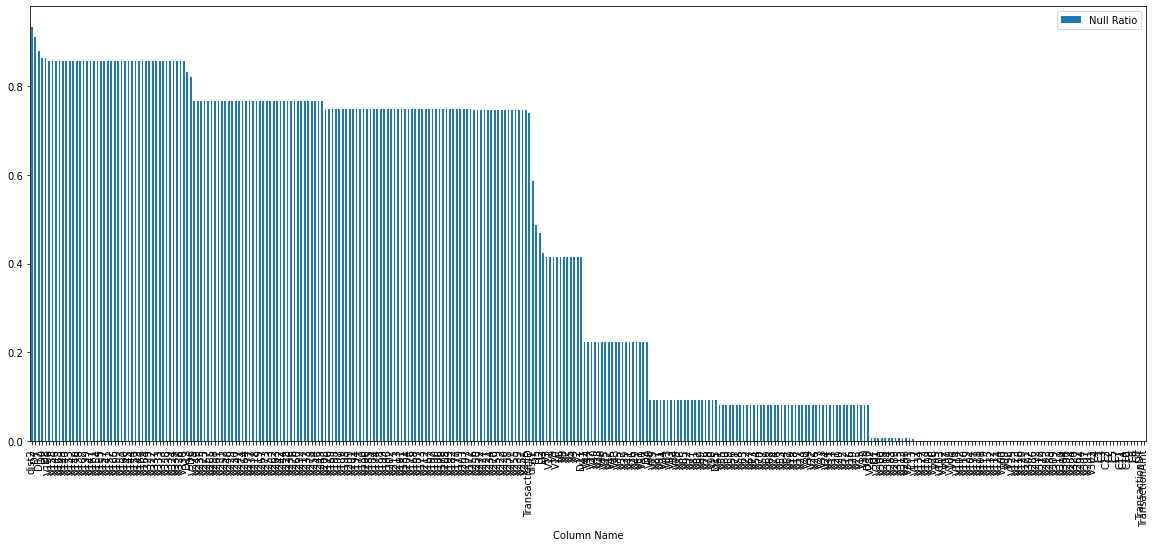

In [ ]:
# Let's display the plot.
nullDf.plot(x="Column Name", y="Null Ratio", kind="bar", figsize=(20,8))

In [ ]:
# Drop all columns that have more than x% of their values missing.
thresholdFilter = nullDf["Null Ratio"] >= nullValueThreshold
columnsToDrop = nullDf[thresholdFilter]["Column Name"].values
print("Preview of Columns to Drop:", columnsToDrop[0:5])

df.drop(columns=columnsToDrop, inplace=True)

Preview of Columns to Drop: ['dist2' 'D7']


In [ ]:
# Note that the dimensions have changed after deleting some of the columns.
print("df:", df.shape)

df: (1097231, 370)


In [ ]:
# We remove the variables from our quantitative variable list.
quantVarSet = quantVarSet.difference(columnsToDrop)
print("There are {} quantitative variables left".format(len(quantVarSet)))

There are 321 quantitative variables left


# Replacing Missing Quantitative Variable Values With Average Value

In [ ]:
# Now we replace missing values with the average.
for column in quantVarSet:
  average = df[column].mean()
  df[column].fillna(value=average, inplace=True)

In [ ]:
# Now check to see if there are any null values left in these columns.
totalNullValues = 0
for column in quantVarSet:
  nullValues = df[column].isna().values.sum()
  totalNullValues += nullValues

print("Total null values:", totalNullValues)

Total null values: 0


# Dummy Variable Creation & Qualitative Variable Selection

Note: The NaN values in each column are also considered as a separate field in the dummy variable creation.

In [ ]:
# Below we list how many dummy variables would result from each of our categorical variables.

nNewColumns = 0
for column in categoricalVariables:
  uniqueValues = df[column].unique()
  print( "{}: {}".format(column, len(uniqueValues) ) )
  nNewColumns += len(uniqueValues)

print("Number of new columns:", nNewColumns)

ProductCD: 5
card1: 17091
card2: 502
card3: 134
card4: 5
card5: 139
card6: 5
addr1: 442
addr2: 94
P_emaildomain: 61
R_emaildomain: 61
M1: 3
M2: 3
M3: 3
M4: 4
M5: 3
M6: 3
M7: 3
M8: 3
M9: 3
DeviceType: 3
DeviceInfo: 2800
id-12: 3
id-13: 56
id-14: 29
id-15: 4
id-16: 3
id-17: 128
id-18: 20
id-19: 569
id-20: 548
id-21: 735
id-22: 36
id-23: 4
id-24: 18
id-25: 441
id-26: 116
id-27: 3
id-28: 3
id-29: 3
id-30: 88
id-31: 173
id-32: 7
id-33: 462
id-34: 5
id-35: 3
id-36: 3
id-37: 3
id-38: 3
Number of new columns: 24836


In [ ]:
# Note that card1 would result in 17091 dummy variables. 
# DeviceInfo would result in 2800 dummy variables.
# We can optionally run the below lines of code to eliminate either one or both of them from the dataset.

df.drop(columns=['card1'], inplace=True)
categoricalVariables.remove('card1')

# df.drop(columns=['DeviceInfo'], inplace=True)
# categoricalVariables.remove('DeviceInfo')

In [ ]:
# We create an empty dataframe that we will add to as we go.
# emptyDf = pd.DataFrame()

# We make a list of our dummy features and append as we go.
dummyFeatureList = []

# Obtain the p-values for each series of dummy variables.
for feature in categoricalVariables:
  print(feature)
  dummyDf = pd.get_dummies(train[feature], prefix=feature, dummy_na=True, sparse=True)
  chi2Stats, pValues = fs.chi2(dummyDf.values, training_labels)
  
  # Iterate over the p-values and only select features with a p-value below 0.01.
  featureList = []
  for i in range(len(pValues)):
    p = pValues[i]
    feature = dummyDf.columns[i]
    if p <= 0.01:
        featureList.append(feature)

  dummyFeatureList.extend(featureList)

  # We append the dummy df to our empty df.
  # emptyDf = pd.concat([emptyDf, dummyDf], axis=1)


ProductCD
card2
card3
card4
card5
card6
addr1
addr2
P_emaildomain
R_emaildomain
M1
M2
M3
M4
M5
M6
M7
M8
M9
DeviceType
DeviceInfo
id-12
id-13
id-14
id-15
id-16
id-17
id-18
id-19
id-20
id-21
id-22
id-23
id-24
id-25
id-26
id-27
id-28
id-29
id-30
id-31
id-32
id-33
id-34
id-35
id-36
id-37
id-38


In [ ]:
# Let's check the size of our dummy dataframe.
len(dummyFeatureList)

618

In [ ]:
# Now, we have all of the column names that should remain in the training dummy df.
# We must simply apply this info to filter certain values out of the combined training - testing dummy df.
combinedDummyDf = pd.get_dummies(df[categoricalVariables], columns=categoricalVariables, dummy_na=True, sparse=True)

In [ ]:
combinedDummyDf = combinedDummyDf[dummyFeatureList]

# Then, we delete all categorical values from the combined df.
df.drop(columns=categoricalVariables, inplace=True)

# We append the created dummy variables to the combined df.
df = pd.concat([df, combinedDummyDf], axis = 1)

In [ ]:
# Take a look at our dimensions.
df.shape

(1097231, 939)

In [ ]:
# We obtain a list of our new dummy variables.
newDummyFeatures = []
for feature in df.columns:
  if "_" in feature:
    newDummyFeatures.append(feature)

# Convert the dataframe back into a dense dataframe. XG Boost won't work otherwise.
df[newDummyFeatures] = df[newDummyFeatures].sparse.to_dense()

# Split the Data into Training, Validation and Testing Sets

In [ ]:
# Divide the data back into training and testing datasets.

# df = df.values
train = df.iloc[0:nTrainRows]
test = df.iloc[nTrainRows:]
del df

In [ ]:
# Check on our dimensions again.
print("train:", train.shape)
print("test:", test.shape)

train: (590540, 939)
test: (506691, 939)


In [ ]:
# Optional export of our preprocessed data.
if exportData:
  train.to_pickle('train')
  test.to_pickle('test')
  np.save('training_labels.npy', train)

## Fitting Simple Models

In [ ]:
def kaggleExportProbs(trainedModel, testFeatures, outputFile):
  # Predict probability.
  predictions = trainedModel.predict_proba(testFeatures)
  predictions = predictions[:, 1]

  # Create a dataframe with TransactionID and prediction.
  dfDict = { "TransactionID" : testTransactionID, "IsFraud" : predictions }
  submission = pd.DataFrame(dfDict)

  # Output the df to a csv file.
  submission.to_csv(outputFile, index=False)

## Support Vector Machine

In [ ]:
if runSupportVectorMachine:

  from sklearn.svm import LinearSVC
  from sklearn.calibration import CalibratedClassifierCV

  # Train the model.
  model = LinearSVC()
  clf = CalibratedClassifierCV(model) 
  clf.fit(train, training_labels)

  # Output a csv file.
  kaggleExportProbs(clf, test, 'Support Vector Machine.csv')

## K Nearest Neighbors

In [ ]:
# This one can't seem to finish.

if runKNearestNeighbors:

  from sklearn.neighbors import KNeighborsClassifier

  # Train the model.
  model = KNeighborsClassifier(n_neighbors=2)
  model.fit(train, training_labels)

  # Output a csv file.
  kaggleExport(model, test, 'K Nearest Neighbors.csv')

## Naive Bayes

In [ ]:
if runNaiveBayes:

  from sklearn.naive_bayes import GaussianNB

  # Train the model.
  model = GaussianNB()
  model.fit(train, training_labels)

  # Output a csv file.
  kaggleExportProbs(model, test, 'Naive Bayes Classifier.csv')

## Decision Tree

In [ ]:
if runDecisionTree:

  from sklearn.tree import DecisionTreeClassifier

  # Train the model.
  model = DecisionTreeClassifier(criterion = "entropy")
  model.fit(train, training_labels)

  # Output a csv file.
  kaggleExportProbs(model, test, 'Decision Tree Classifier.csv')

## Random Forest

In [ ]:
if runRandomForest:

  from sklearn.ensemble import RandomForestClassifier

  # Train the model.
  model = RandomForestClassifier(criterion = "entropy")
  model.fit(train, training_labels)

  # Output a csv file.
  kaggleExportProbs(model, test, 'Random Forest Classifier.csv')

## Logistic Regression

In [ ]:
if runLogisticRegression:

  from sklearn.linear_model import LogisticRegression

  # Train the model.
  model = LogisticRegression()
  model.fit(train, training_labels)

  # Output a csv file.
  kaggleExportProbs(model, test, 'Logistic Regression.csv')

## XG Boost

In [ ]:
if runXGBoost:

  # from xgboost import XGBClassifier

  # # Train the model.
  # model = XGBClassifier()
  # model.fit(train, training_labels)

  xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)

  # Output a csv file.
  kaggleExportProbs(model, test, 'XG Boost.csv')